In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from itertools import permutations, combinations,product

In [2]:
df = pd.read_csv('./dataset/summary.csv') # treatment response dataset
df_source = pd.read_csv('./dataset/source.csv')  # block id vs. dataset vs. assay
df_drug = pd.read_csv('./dataset/drug.csv')  # drug information
df_concen = pd.read_csv('./dataset/concentration.csv')  # concentration
df_cellline = pd.read_csv('./dataset/cell_line.csv') # cell line information
df_disease = pd.read_csv('./dataset/disease.csv') # indication of drugs (disease)

/tmp/ipykernel_5293/941220709.py:1: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./dataset/summary.csv') # treatment response dataset
/tmp/ipykernel_5293/941220709.py:4: DtypeWarning: Columns (5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_concen = pd.read_csv('./dataset/concentration.csv')  # concentration


In [5]:
# QC of cell line expression data
cancer_genes = pd.read_csv('./dataset/cancer_genes.csv')
cancer_genes.driver_gene_status.unique()

array(['Tumour Suppressor', 'Oncogene'], dtype=object)

In [19]:
# clean the cell line name (all capital)
df_comb= df[-(df["drug_row"].isnull() | df["drug_col"].isnull())].merge(df_concen[['block_id', 'study_name']].drop_duplicates(), how = 'left', on = 'block_id').reset_index(drop = True)
df_comb["cell_line_name"] = [re.sub(r"[^a-zA-Z0-9]+", '', k).upper() for k in df_comb["cell_line_name"]]
# cell line that use its synonyms in the CCLE 
df_comb["cell_line_name"] = df_comb["cell_line_name"].replace(to_replace = ["MSTO","U251","OVCAR3"],value = ["MSTO211H","U251MGDM","NIHOVCAR3"])
# remove experiments with self combination. should not have synergy score
df_comb = df_comb[df_comb.drug_col!=df_comb.drug_row]
df_comb
df_comb.to_csv('./dataset/cleaned_summary.csv', index = False)

# QC of the concentration range in monotherapy dose-response curve
# two kinds of concentration interval: Linear and log

In [7]:
# get monotherapy
df_row = df_comb[["block_id","drug_row","ic50_row","ri_row","css_row", "cell_line_name", "study_name"]].rename(columns ={"drug_row":"drug", "ic50_row":"ic50", "ri_row":"ri", "css_row":"css"})
df_col = df_comb[["block_id","drug_col","ic50_col","ri_col","css_col", "cell_line_name", "study_name"]].rename(columns ={"drug_col":"drug", "ic50_col":"ic50", "ri_col":"ri", "css_col":"css"})
df_tmp = pd.concat([df_row, df_col])
df_tmp['drug|cell'] = df_tmp['drug']+'|'+df_tmp['cell_line_name']
df_tmp['block_id|drug'] = df_tmp['block_id'].astype(str)+'|'+df_tmp['drug']
df_tmp.to_csv('./dataset/processed_monotherapy_response.csv', index = False)

In [8]:
# check data sanity
df_tmp
"""
block_id	drug	ic50	ri	css	cell_line_name	study_name	drug|cell	block_id|drug
0	1	5-FU	5.126836	11.471	22.545	A2058	ONEIL	5-FU|A2058	1|5-FU
1	2	5-FU	5.126836	11.471	24.135	A2058	ONEIL	5-FU|A2058	2|5-FU
2	3	5-FU	5.126836	11.471	25.561	A2058	ONEIL	5-FU|A2058	3|5-FU
3	4	5-FU	5.126836	11.471	16.661	A2058	ONEIL	5-FU|A2058	4|5-FU
4	5	5-FU	5.126836	11.471	76.501	A2058	ONEIL	5-FU|A2058	5|5-FU
...	...	...	...	...	...	...	...	...	...
466028	466255	TARIQUIDAR	0.018344	-2.285	-9.740	KBCHR8511	NCATS_MDR_CS	TARIQUIDAR|KBCHR8511	466255|TARIQUIDAR
466029	466256	TARIQUIDAR	0.255526	-3.031	-6.765	KBCHR8511	NCATS_MDR_CS	TARIQUIDAR|KBCHR8511	466256|TARIQUIDAR
466030	466257	TARIQUIDAR	0.304013	-1.943	-7.087	KBCHR8511	NCATS_MDR_CS	TARIQUIDAR|KBCHR8511	466257|TARIQUIDAR
466031	466258	TARIQUIDAR	0.087976	-8.227	56.256	KBCHR8511	NCATS_MDR_CS	TARIQUIDAR|KBCHR8511	466258|TARIQUIDAR
466032	466259	TARIQUIDAR	0.005192	-16.920	31.290	KBCHR8511	NCATS_MDR_CS	TARIQUIDAR|KBCHR8511	466259|TARIQUIDAR
932066 rows × 9 columns
"""

'\nblock_id\tdrug\tic50\tri\tcss\tcell_line_name\tstudy_name\tdrug|cell\tblock_id|drug\n0\t1\t5-FU\t5.126836\t11.471\t22.545\tA2058\tONEIL\t5-FU|A2058\t1|5-FU\n1\t2\t5-FU\t5.126836\t11.471\t24.135\tA2058\tONEIL\t5-FU|A2058\t2|5-FU\n2\t3\t5-FU\t5.126836\t11.471\t25.561\tA2058\tONEIL\t5-FU|A2058\t3|5-FU\n3\t4\t5-FU\t5.126836\t11.471\t16.661\tA2058\tONEIL\t5-FU|A2058\t4|5-FU\n4\t5\t5-FU\t5.126836\t11.471\t76.501\tA2058\tONEIL\t5-FU|A2058\t5|5-FU\n...\t...\t...\t...\t...\t...\t...\t...\t...\t...\n466028\t466255\tTARIQUIDAR\t0.018344\t-2.285\t-9.740\tKBCHR8511\tNCATS_MDR_CS\tTARIQUIDAR|KBCHR8511\t466255|TARIQUIDAR\n466029\t466256\tTARIQUIDAR\t0.255526\t-3.031\t-6.765\tKBCHR8511\tNCATS_MDR_CS\tTARIQUIDAR|KBCHR8511\t466256|TARIQUIDAR\n466030\t466257\tTARIQUIDAR\t0.304013\t-1.943\t-7.087\tKBCHR8511\tNCATS_MDR_CS\tTARIQUIDAR|KBCHR8511\t466257|TARIQUIDAR\n466031\t466258\tTARIQUIDAR\t0.087976\t-8.227\t56.256\tKBCHR8511\tNCATS_MDR_CS\tTARIQUIDAR|KBCHR8511\t466258|TARIQUIDAR\n466032\t466259\tTARIQU

In [9]:
def within_dataset_replicates(df_comb, study_name = "ONEIL" ):
    """ Rep for IC50 and RI

    """
    from scipy import stats
    import itertools
    import matplotlib.pyplot as plt

    def within_dataset_corr_helper_func(score):
        """
        score: list
        list of all replicate's score
        """
        pairs = list(permutations(list(score), 2))
        pairs = np.asarray(pairs)
        return pairs
    
    if study_name == 'all':  #across all datasets
        df_sub = df_comb
        all_reps = df_comb.groupby("drug|cell").size().sort_values(ascending=False).reset_index()
    else:
        df_sub = df_comb[df_comb["study_name"] == study_name]
        all_reps = df_comb[df_comb["study_name"] == study_name].groupby("drug|cell").size().sort_values(ascending=False).reset_index()
    
     
    reps=all_reps[all_reps[0]>1]['drug|cell']
    
    if len(reps)<=1:
        print("No replicates!!")
    else:
        #make a distribution plot of replicates
        plt.hist(all_reps[0])
        #plt.savefig(study_name.replace('(','_').replace('/','_').replace('+','_').replace(')','')   + '.png')
        plt.show()
        print(len(reps))
        
        df_sub = df_sub[df_sub['drug|cell'].isin(reps)]
        study_synergy = df_sub[['ic50', 'ri',"drug|cell"]]
        a = study_synergy[study_synergy["drug|cell"].duplicated(keep=False)].groupby("drug|cell").agg(list).apply(
        {'ic50':within_dataset_corr_helper_func,
        'ri':within_dataset_corr_helper_func}
        ).reset_index()
        result = []
        
        for synergy_score in ['ic50', 'ri']:
            score = np.concatenate(a[synergy_score]).T
            #print(len(score[0]), len(score[1]))
            cor, p = stats.pearsonr(score[0], score[1])
            #print(cor)
            result.append(cor)

        return pd.DataFrame(data = {"monotherapy_score": ["ic50","ri"],"correlation": result, "dataset1": study_name, "dataset2": study_name})

In [10]:
def inter_dataset_replicates(df, study_name_1, study_name_2):
    """rep for IC50 and RI

    """
    from scipy import stats
    import itertools
    import matplotlib.pyplot as plt

    df_sub_1 = df[df["study_name"] == study_name_1]
    df_sub_2 = df[df["study_name"] == study_name_2]

    overlap_exp = set(df_sub_1["drug|cell"]).intersection(set(df_sub_2["drug|cell"]))

    df_sub_1_overlap_filtered = df_sub_1[df_sub_1["drug|cell"].isin(overlap_exp)]

    df_sub_2_overlap_filtered = df_sub_2[df_sub_2["drug|cell"].isin(overlap_exp)]

    if len(overlap_exp) == 0:
        print("No replicates betwen " + study_name_1 + " and " + study_name_2)
    else:
        print(len(overlap_exp), "monothreapy replicates!")
        paired_result = pd.DataFrame(columns = ["ic50","ri"])
        
        for k in ["ic50","ri"]:
            tmp = []
            for group_name,value in df_sub_1_overlap_filtered.groupby("drug|cell"):
                pairs = list(product(list(df_sub_1_overlap_filtered[df_sub_1_overlap_filtered["drug|cell"] == group_name][k]), 
                             list(df_sub_2_overlap_filtered[df_sub_2_overlap_filtered["drug|cell"] == group_name][k])))
  

                tmp.extend(pairs)
            paired_result[k] = tmp

        result = []
        
        for synergy_score in ["ic50","ri"]:

             cor, p = stats.pearsonr(([x[0] for x in paired_result[synergy_score]]), ([x[1] for x in paired_result[synergy_score]]))
            # #print(cor)
             result.append(cor)

        #eturn paired_result
        return pd.DataFrame( data = {"monotherapy_score": ["ic50","ri"],"correlation": result, "dataset1": study_name_1, "dataset2":study_name_2})

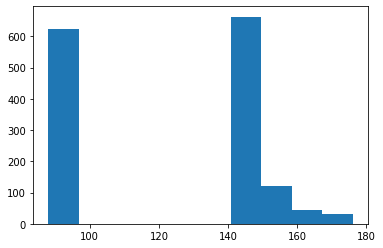

1482


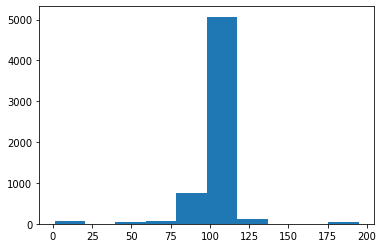

6174
No replicates!!


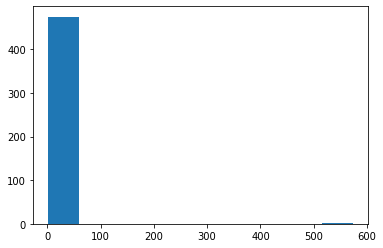

477


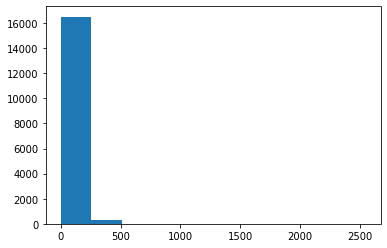

11251
ONEIL and ALMANAC
126 monothreapy replicates!
  monotherapy_score  correlation dataset1 dataset2
0              ic50     0.083941    ONEIL  ALMANAC
1                ri     0.450527    ONEIL  ALMANAC
ONEIL and FORCINA
No replicates betwen ONEIL and FORCINA
None
ONEIL and Mathews
No replicates betwen ONEIL and Mathews
None
ALMANAC and FORCINA
No replicates betwen ALMANAC and FORCINA
None
ALMANAC and Mathews
No replicates betwen ALMANAC and Mathews
None
FORCINA and Mathews
No replicates betwen FORCINA and Mathews
None


In [26]:
all_rep = []
for study in ["ONEIL", "ALMANAC", "FORCINA", "Mathews", "all"]:
    rep = within_dataset_replicates(df_tmp, study)
    all_rep.append(rep)

for study_name1, study_name2 in list(combinations(["ONEIL", "ALMANAC", "FORCINA", "Mathews"],2)):
    print(study_name1 + " and " + study_name2 )
    rep = inter_dataset_replicates(df_tmp, study_name1, study_name2)
    print(rep)
    try:
        all_rep.append(rep)
    except:
        pass
all_rep = pd.concat(all_rep)
all_rep.to_csv('monotherapy_efficacy_rep.csv', index = False)

# replicability of monothreapy dose response curve

In [11]:
# replicability of monothreapy dose response curve
# QC of all drug resppnse data
df_concen_new = df_concen[df_concen.study_name.isin(['ONEIL', 'ALMANAC', 'FORCINA', 'Mathews'])].reset_index(drop=True) # select the four study used
df_concen_new =  df_concen_new[df_concen_new.drug_row != df_concen_new.drug_col]
df_concen_r = df_concen_new[df_concen_new.conc_c == 0].reset_index(drop = True) # column drug
df_concen_c = df_concen_new[df_concen_new.conc_r == 0].reset_index(drop = True) # column drug

In [12]:
#un imputed
df_tmp = pd.concat([df_concen_c.rename(columns={"conc_c":"conc", "drug_col":"drug"})[["block_id", "conc", "inhibition", "drug", "cell_line_name", "study_name"]],df_concen_r.rename(columns={"conc_r":"conc", "drug_row":"drug"})[["block_id", "conc", "inhibition", "drug", "cell_line_name", "study_name"]]])
df_tmp['block_id|drug'] = df_tmp['block_id'].astype(str)+'|'+df_tmp['drug']
df_tmp.to_csv('./dataset/processed_concentration.csv', index = False)

In [31]:
def within_dataset_replicates_drc(df_comb, study_name):
    """
    """
    from scipy import stats
    import itertools
    import matplotlib.pyplot as plt

    def within_dataset_corr_helper_func(score):
        """
        score: list
        list of all replicate's score
        """
        pairs = list(permutations(list(score), 2))
        pairs = np.asarray(pairs)
        return pairs

    if study_name =="all":
        df_sub = df_comb
        all_reps = df_comb.groupby("drug|cell").size().sort_values(ascending=False).reset_index()
    else:
        df_sub = df_comb[df_comb["study_name"] == study_name]
        all_reps = df_comb[df_comb["study_name"] == study_name].groupby("drug|cell").size().sort_values(ascending=False).reset_index() 
     
    reps=all_reps[all_reps[0]>1]['drug|cell']
    
    if len(reps)<=1:
        print("No replicates!!")
    else:
        #make a distribution plot of replicates
        plt.hist(all_reps[0])
        #plt.savefig(('all'+str(study_name)).replace('(','_').replace('/','_').replace('+','_').replace(')','')   + '.png')
        plt.show()
        
        df_sub = df_sub[df_sub['drug|cell'].isin(reps)]
        study_synergy = df_sub[['inhibition_min','inhibition_mean', 'inhibition_median', 'inhibition_max',"drug|cell"]]
        a = study_synergy[study_synergy["drug|cell"].duplicated(keep=False)].groupby("drug|cell").agg(list).apply(
        {'inhibition_min':within_dataset_corr_helper_func,
        'inhibition_mean':within_dataset_corr_helper_func,
        'inhibition_median':within_dataset_corr_helper_func,
        'inhibition_max':within_dataset_corr_helper_func,}
        ).reset_index()
        result = []
        
        for synergy_score in ['inhibition_min', 'inhibition_mean', 'inhibition_median','inhibition_max']:
            score = np.concatenate(a[synergy_score]).T
            #print(len(score[0]), len(score[1]))
            cor, p = stats.pearsonr(score[0], score[1])
            #print(cor)
            result.append(cor)

        return pd.DataFrame( data = {"score": ['inhibition_min', 'inhibition_mean','inhibition_median','inhibition_max'],"correlation": result, "dataset1" : study_name, "dataset2" : study_name})

In [32]:
def inter_dataset_replicates_drc(df, study_name_1, study_name_2):
    """

    """
    from scipy import stats
    import itertools
    import matplotlib.pyplot as plt

    df_sub_1 = df[df["study_name"] == study_name_1]
    df_sub_2 = df[df["study_name"] == study_name_2]

    overlap_exp = set(df_sub_1["drug|cell"]).intersection(set(df_sub_2["drug|cell"]))

    df_sub_1_overlap_filtered = df_sub_1[df_sub_1["drug|cell"].isin(overlap_exp)]

    df_sub_2_overlap_filtered = df_sub_2[df_sub_2["drug|cell"].isin(overlap_exp)]

    if len(overlap_exp) == 0:
        print("No replicates betwen " + study_name_1 + " and " + study_name_2)
    else:
        print(len(overlap_exp), "monothreapy replicates!")
        paired_result = pd.DataFrame(columns = ['inhibition_min', 'inhibition_mean', 'inhibition_median','inhibition_max'])
        
        for k in ['inhibition_min', 'inhibition_mean', 'inhibition_median','inhibition_max']:
            tmp = []
            for group_name,value in df_sub_1_overlap_filtered.groupby("drug|cell"):
                pairs = list(product(list(df_sub_1_overlap_filtered[df_sub_1_overlap_filtered["drug|cell"] == group_name][k]), 
                             list(df_sub_2_overlap_filtered[df_sub_2_overlap_filtered["drug|cell"] == group_name][k])))
  

                tmp.extend(pairs)
            paired_result[k] = tmp

        result = []
        
        for synergy_score in ['inhibition_min', 'inhibition_mean', 'inhibition_median','inhibition_max']:

             cor, p = stats.pearsonr(([x[0] for x in paired_result[synergy_score]]), ([x[1] for x in paired_result[synergy_score]]))
            # #print(cor)
             result.append(cor)

        #eturn paired_result
        return pd.DataFrame( data = {"monotherapy_score": ['inhibition_min', 'inhibition_mean', 'inhibition_median','inhibition_max'],"correlation": result, "dataset_1": study_name_1, "dataset_2":study_name_2})

In [ ]:
# unimputed: preconpute distribution statistics
df_tmp['drug|cell'] = df_tmp.drug +'|'+df_tmp.cell_line_name 
tmp = df_tmp.groupby(['drug|cell', 'block_id', 'study_name']).agg( inhibition_min=('inhibition',min), 
inhibition_mean = ('inhibition',np.mean), inhibition_median =('inhibition', np.median),inhibition_max = ('inhibition',max)).reset_index()
tmp

In [80]:
d = []
for study in ["ONEIL", "ALMANAC", "FORCINA", "Mathews", "all"]:
    rep = within_dataset_replicates_drc(tmp, study)
    d.append(rep)

for study_name_1, study_name_2 in list(combinations(["ONEIL", "ALMANAC", "FORCINA", "Mathews"],2)):
    print(study_name_1 + " and " + study_name_2 )
    rep = inter_dataset_replicates_drc(tmp, study_name_1, study_name_2)
    print(rep)
    try:
        d.append(rep)
    except:
        pass
all_rep = pd.concat(d)
all_rep.to_csv('monotherapy_drc_rep.csv', index = False)

ONEIL and ALMANAC
126 monothreapy replicates!
   monotherapy_score  correlation dataset_1 dataset_2
0     inhibition_min     0.209188     ONEIL   ALMANAC
1    inhibition_mean     0.457940     ONEIL   ALMANAC
2  inhibition_median     0.297866     ONEIL   ALMANAC
3     inhibition_max     0.451969     ONEIL   ALMANAC
ONEIL and FORCINA
No replicates betwen ONEIL and FORCINA
None
ONEIL and Mathews
No replicates betwen ONEIL and Mathews
None
ALMANAC and FORCINA
No replicates betwen ALMANAC and FORCINA
None
ALMANAC and Mathews
No replicates betwen ALMANAC and Mathews
None
FORCINA and Mathews
No replicates betwen FORCINA and Mathews
None


# replicates between combination responses

In [29]:
df_comb.groupby('study_name').size().reset_index(name='Number of Samples').merge(
df_comb.groupby('study_name')['drug_row'].nunique().reset_index(name='Number of Different Row Drugs'),on='study_name'
).merge(
df_comb.groupby('study_name')['drug_col'].nunique().reset_index(name='Number of Different Column Drugs'),on='study_name'
).merge(
df_comb.groupby('study_name')['cell_line_name'].nunique().reset_index(name='Number of Different Cell Lines'),on='study_name'
)


,study_name,Number of Samples,Number of Different Row Drugs,Number of Different Column Drugs,Number of Different Cell Lines
0,ALMANAC,311604,103,102,60
1,CLOUD,40160,283,283,1
2,FORCINA,1818,1818,1,1
3,Mathews,1119,477,13,1
4,NCATS_2D_3D,69,4,4,2
5,NCATS_ATL,30,17,6,1
6,NCATS_DIPG,8778,2450,123,2
7,NCATS_ES(FAKi/AURKi),1875,1873,1,1
8,NCATS_ES(Nampt+PARP),4625,91,81,4
9,NCATS_HL,2602,1868,33,4


In [30]:
#df_concen[df_concen.block_id.isin(df_comb.block_id)]
df_concen[df_concen.block_id ==1][(df_concen.conc_r == 0)|(df_concen.conc_c ==0)]

/home/rayezh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,block_id,conc_r,conc_c,inhibition,drug_row,drug_col,conc_r_unit,conc_c_unit,cell_line_name,drug_row_cid,drug_col_cid,cellosaurus_accession,study_name
0,1,0.00,0.00,-0.000626,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
1,1,0.00,0.35,-1.993009,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
2,1,0.00,1.08,-0.957673,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
3,1,0.00,3.25,0.069628,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
4,1,0.00,10.00,1.138798,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
5,1,0.35,0.00,-1.753521,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
10,1,1.08,0.00,2.410257,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
15,1,3.25,0.00,15.050055,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL
20,1,10.00,0.00,39.706770,5-FU,ABT-888,uM,uM,A2058,3385,11960529,CVCL_1059,ONEIL


In [31]:
all_study_id = sorted(df_comb.block_id.unique()) # study number [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
all_drug_number = len(set(list(df_comb.drug_col.unique())+list(df_comb.drug_row.unique()))) # total drugs: 4150
all_drug_number

4150

In [32]:
CCLE = pd.read_csv('./dataset/CCLE/CCLE_expression.csv').rename(columns={"Unnamed: 0": "DepMap_ID"})
CCLE_sample_info = pd.read_csv('./dataset/CCLE/sample_info.csv')

In [33]:
CCLE_sample_info

,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,...,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,culture_type
0,ACH-000001,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,Female,ATCC,CVCL_0465,2201.0,...,Ovarian Cancer,"Adenocarcinoma, high grade serous",60.0,SIDM00105,NaN,ovary,ovary_adenocarcinoma,high_grade_serous,NaN,Adherent
1,ACH-000002,HL-60,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,Female,ATCC,CVCL_0002,55.0,...,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",35.0,SIDM00829,NaN,blood,AML,M3,NaN,Suspension
2,ACH-000003,CACO2,CACO2,CACO2_LARGE_INTESTINE,"CACO2, CaCo-2",NaN,Male,ATCC,CVCL_0025,NaN,...,Colon/Colorectal Cancer,Adenocarcinoma,NaN,SIDM00891,NaN,colorectal,colorectal_adenocarcinoma,NaN,NaN,not found
3,ACH-000004,HEL,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,Male,DSMZ,CVCL_0001,783.0,...,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",30.0,SIDM00594,NaN,blood,AML,M6,NaN,Suspension
4,ACH-000005,HEL 92.1.7,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,ATCC,CVCL_2481,NaN,...,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",30.0,SIDM00593,NaN,blood,AML,M6,NaN,Suspension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,ACH-002659,JVE-127,JVE127,JVE127_COLON,NaN,NaN,Male,DSMZ,NaN,NaN,...,Colon/Colorectal Cancer,Adenocarcinoma,60.0,NaN,NaN,colorectal,colorectal_adenocarcinoma,NaN,NaN,Adherent
1825,ACH-002687,WM3772F,WM3772F,WM3772F_EYE,NaN,NaN,Female,"Rockland Immunochemicals, Inc.",NaN,NaN,...,Eye Cancer,Uveal Melanoma,NaN,NaN,NaN,eye,uveal_melanoma,NaN,NaN,Adherent
1826,ACH-002800,NCC-MPNST2-C1,NCCMPNST2C1,NaN,NaN,NaN,Unknown,Academic lab,NaN,NaN,...,Sarcoma,MPNST,NaN,NaN,Patient-derived model,peripheral_nervous_system,MPNST,NaN,NaN,Adherent
1827,ACH-002874,A375_RPMI,A375RPMI,NaN,NaN,NaN,Female,ATCC,NaN,NaN,...,Skin Cancer,Melanoma,54.0,NaN,NaN,skin,NaN,NaN,NaN,not found


In [14]:
CCLE_new = CCLE.merge(CCLE_sample_info, on = "DepMap_ID", how = "left")
CCLE_new

,DepMap_ID,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),...,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,culture_type
0,ACH-001113,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,...,Lung Cancer,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",69.0,SIDM01226,NaN,lung,NSCLC,NSCLC_squamous,NaN,Adherent
1,ACH-001289,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,...,Rhabdoid,Atypical Teratoid Rhabdoid Tumor (ATRT),NaN,NaN,NaN,soft_tissue,ATRT,NaN,NaN,Suspension
2,ACH-001339,3.779260,0.000000,7.346425,2.339137,4.254745,0.056584,1.339137,6.724241,3.671293,...,Skin Cancer,Melanoma,14.0,SIDM00514,NaN,skin,melanoma,NaN,NaN,Adherent
3,ACH-001538,5.726831,0.000000,7.086189,2.543496,3.102658,0.000000,5.914565,6.099716,4.475733,...,Bile Duct Cancer,"Cholangiocarcinoma, intrahepatic",58.0,NaN,NaN,bile_duct,cholangiocarcinoma,intrahepatic,NaN,Adherent
4,ACH-000242,7.465648,0.000000,6.435462,2.414136,3.864929,0.831877,7.198003,5.452530,7.112492,...,Bladder Cancer,Transitional Cell Carcinoma,63.0,SIDM01085,NaN,urinary_tract,bladder_carcinoma,bladder_transitional_cell,NaN,Adherent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,ACH-000750,4.173127,0.000000,6.400879,1.807355,3.303050,0.014355,0.137504,4.944858,4.528571,...,Skin Cancer,Melanoma,58.0,SIDM00149,NaN,skin,melanoma,NaN,NaN,NaN
1389,ACH-000285,0.097611,0.000000,6.428276,3.257011,4.980482,0.411426,0.124328,0.704872,4.829342,...,Lymphoma,Diffuse Large B-cell Lymphoma (DLBCL),NaN,NaN,NaN,lymphocyte,non_hodgkin_lymphoma,DLBCL,NaN,Suspension
1390,ACH-001858,5.045268,0.000000,6.991749,1.807355,3.270529,0.028569,3.333424,6.819796,5.395063,...,Bile Duct Cancer,"Cholangiocarcinoma, intrahepatic",NaN,SIDM00275,NaN,bile_duct,cholangiocarcinoma,intrahepatic,NaN,Adherent
1391,ACH-001997,5.805292,0.000000,7.792855,2.482848,3.903038,0.028569,4.124328,6.816600,4.458119,...,Bile Duct Cancer,"Cholangiocarcinoma, extrahepatic",NaN,NaN,NaN,bile_duct,cholangiocarcinoma,extrahepatic,NaN,Adherent


In [34]:
set(df_comb["cell_line_name"].unique()).issubset(set(CCLE_new["cell_line_name"]))

NameError: name 'CCLE_new' is not defined

## Combinatorial therapy dataset corresponding CCLE 

In [21]:
df_comb_CCLE = CCLE_new[CCLE_new["stripped_cell_line_name"].isin(set(df_comb_cell_line_name_stripped["stripped_cell_line_name"]) & (set(CCLE_new["stripped_cell_line_name"])))]

df_comb_CCLE

,DepMap_ID,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),...,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,culture_type
22,ACH-000421,5.257011,0.333424,6.924219,2.965323,4.761817,0.189034,0.250962,6.909053,5.875043,...,Colon/Colorectal Cancer,Adenocarcinoma,53.0,SIDM00833,NaN,colorectal,colorectal_adenocarcinoma,NaN,NaN,Adherent
43,ACH-000754,0.070389,0.000000,5.915999,2.039138,3.812498,0.014355,0.111031,3.806324,4.224966,...,Lymphoma,"B-cell, Hodgkins",37.0,SIDM00327,NaN,lymphocyte,hodgkin_lymphoma,NaN,NaN,NaN
83,ACH-000376,4.203201,0.000000,6.549361,2.077243,4.117695,0.028569,5.191010,6.536830,4.711495,...,Brain Cancer,Glioblastoma,67.0,SIDM00084,NaN,central_nervous_system,glioma,glioblastoma,NaN,Adherent
89,ACH-000035,4.888013,0.028569,7.254840,2.289834,3.795975,0.111031,0.367371,6.252855,4.214125,...,Lung Cancer,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",27.0,SIDM00745,NaN,lung,NSCLC,NSCLC_adenocarcinoma,NaN,Adherent
92,ACH-000322,2.825786,0.000000,7.772677,2.475085,3.909773,0.097611,1.395063,5.981168,3.958843,...,Skin Cancer,Melanoma,29.0,SIDM00695,NaN,skin,melanoma,NaN,NaN,Adherent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,ACH-000900,4.193772,0.000000,7.197413,1.448901,3.107688,0.014355,0.545968,2.906891,4.329124,...,Lung Cancer,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",51.0,SIDM00138,NaN,lung,NSCLC,NSCLC_adenocarcinoma,NaN,Adherent
1363,ACH-000115,2.978196,0.000000,5.832637,2.825786,3.289834,0.000000,0.042644,4.709842,4.727376,...,Prostate Cancer,Adenocarcinoma,59.0,SIDM01077,NaN,prostate,prostate_adenocarcinoma,NaN,NaN,Adherent
1379,ACH-000046,4.173927,0.000000,5.950235,1.974529,3.502076,0.014355,0.948601,6.712045,4.566206,...,Kidney Cancer,Renal Cell Carcinoma,22.0,SIDM00123,NaN,kidney,renal_cell_carcinoma,NaN,NaN,Adherent
1388,ACH-000750,4.173127,0.000000,6.400879,1.807355,3.303050,0.014355,0.137504,4.944858,4.528571,...,Skin Cancer,Melanoma,58.0,SIDM00149,NaN,skin,melanoma,NaN,NaN,NaN


In [22]:
df_mono_cell_line_name_stripped = pd.DataFrame({"stripped_cell_line_name" : [k.replace(" ", "") for k in set([re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in df_mono["cell_line_name"]])]})
df_mono_cell_line_name_stripped["stripped_cell_line_name"]

0       UPCISCC090
1              GAK
2            LS123
3               HT
4            OSC20
           ...    
1924          PL21
1925         CAKI1
1926       1600102
1927         HO1N1
1928        OVCAR4
Name: stripped_cell_line_name, Length: 1929, dtype: object

In [23]:
set(df_mono_cell_line_name_stripped["stripped_cell_line_name"]).difference(set(CCLE_new["stripped_cell_line_name"]))

{'GAK',
 'BT482',
 '1601225',
 '1500045',
 '1600073',
 'Loucy',
 'U87MGATCC',
 '1600003',
 '1600781',
 '1400270',
 'Ri1',
 'SKN3',
 '1600483',
 'IM9',
 '1300098',
 '1300544',
 '1400546',
 '1300195',
 '1600810',
 'NCIH510A',
 '1601220',
 '1600075',
 '1300658',
 '1400800',
 '1600094',
 'U251',
 '1300007',
 'PCI38',
 'AsPC1',
 'Jurkat',
 'KiJK',
 'SF8657',
 '1600562',
 '1601219',
 'MX1',
 '1500616',
 'PECAPJ34cloneC12',
 '1400765',
 'HO1u1',
 '1400422',
 '1300337',
 'A4Fukuda',
 '1600157',
 'Hs611T',
 'Hs895T',
 '1700028',
 'ISTMEL1',
 'Karpas1106P',
 'PL4',
 'NCIH2369',
 'Jiyoye',
 '1400620',
 'Toledo',
 '1400672',
 'WM35',
 'EW11',
 '1700304',
 '1500764',
 '1601011',
 '1400581',
 'Li7',
 'HepG2',
 '1300173',
 '1500975',
 '1601139',
 'SKMG1',
 'SKLU1',
 '1300393',
 'CHSA0011',
 'BT231',
 'Sc1',
 '1500670',
 '1601093',
 'BT340',
 'Hs934T',
 '1500338',
 'RF48',
 '1200211',
 'CHSA8926',
 '1300406',
 '451Lu',
 '1600593',
 '1400559',
 '1601097',
 '1500123',
 '1700021',
 '1700094',
 '1400676',

In [24]:
len(set(df_mono_cell_line_name_stripped["stripped_cell_line_name"]).difference(set(CCLE_new["stripped_cell_line_name"])))

1101

In [25]:
len(set(df_mono_cell_line_name_stripped["stripped_cell_line_name"]))

1927

# check reproducibilty of different experiments

# Calculate replicability
## within datasets

In [44]:
def within_dataset_replicates_comb(df_comb, study_name = "ONEIL" ):
    """

    """
    from scipy import stats
    import itertools
    import matplotlib.pyplot as plt

    def within_dataset_corr_helper_func(score):
        """
        score: list
        list of all replicate's score
        """
        pairs = list(permutations(list(score), 2))
        pairs = np.asarray(pairs)
        return pairs


    if study_name =="all":
        df_sub = df_comb
        all_reps = df_comb.groupby("drug_cellline_pairs").size().sort_values(ascending=False).reset_index()
    else:
        df_sub = df_comb[df_comb["study_name"] == study_name]
        all_reps = df_comb[df_comb["study_name"] == study_name].groupby("drug_cellline_pairs").size().sort_values(ascending=False).reset_index()
    
    reps=all_reps[all_reps[0]>1]['drug_cellline_pairs']
    
    if len(reps)<=1:
        print("No replicates!!")
    else:
        #make a distribution plot of replicates
        plt.hist(all_reps[0])
        #plt.savefig(study_name.replace('(','_').replace('/','_').replace('+','_').replace(')','')   + '.png')
        plt.show()
        
        df_sub = df_sub[df_sub['drug_cellline_pairs'].isin(reps)]
        study_synergy = df_sub[['synergy_zip', 'synergy_bliss','synergy_loewe', 'synergy_hsa', "S", 'css',"drug_cellline_pairs"]]
        a = study_synergy[study_synergy["drug_cellline_pairs"].duplicated(keep=False)].groupby("drug_cellline_pairs").agg(list).apply(
        {'synergy_zip':within_dataset_corr_helper_func,
        'synergy_bliss':within_dataset_corr_helper_func,
        'synergy_loewe':within_dataset_corr_helper_func,
        'synergy_hsa':within_dataset_corr_helper_func, 
        'S': within_dataset_corr_helper_func, 
        "css":within_dataset_corr_helper_func}
        ).reset_index()
        result = []
        
        for synergy_score in ["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa", "S", "css"]:
            score = np.concatenate(a[synergy_score]).T
            #print(len(score[0]), len(score[1]))
            cor, p = stats.pearsonr(score[0], score[1])
            #print(cor)
            result.append(cor)

        return pd.DataFrame( data = {"score": ["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa", "S", "css"],"correlation": result, "dataset1": study_name, "dataset2": study_name})

## inter datasets

In [48]:
def inter_dataset_replicates_comb(df_comb, study_name_1, study_name_2):
    """

    """
    from scipy import stats
    import itertools
    import matplotlib.pyplot as plt

    df_sub_1 = df_comb[df_comb["study_name"] == study_name_1]
    df_sub_2 = df_comb[df_comb["study_name"] == study_name_2]

    overlap_exp = set(df_sub_1["drug_cellline_pairs"]).intersection(set(df_sub_2["drug_cellline_pairs"]))

    df_sub_1_overlap_filtered = df_sub_1[df_sub_1["drug_cellline_pairs"].isin(overlap_exp)]

    df_sub_2_overlap_filtered = df_sub_2[df_sub_2["drug_cellline_pairs"].isin(overlap_exp)]

    if len(overlap_exp) == 0:
        print("No replicates betwen " + study_name_1 + " and " + study_name_2)
    else:

        paired_result = pd.DataFrame(columns = ["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa", "S", "css"])
        
        for k in ["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa", "S", "css"]:
            tmp = []
            for group_name,value in df_sub_1_overlap_filtered.groupby("drug_cellline_pairs"):
                pairs = list(product(list(df_sub_1_overlap_filtered[df_sub_1_overlap_filtered["drug_cellline_pairs"] == group_name][k]), 
                             list(df_sub_2_overlap_filtered[df_sub_2_overlap_filtered["drug_cellline_pairs"] == group_name][k])))
  

                tmp.extend(pairs)
            paired_result[k] = tmp

        result = []
        
        for synergy_score in ["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa", "S", "css"]:

             cor, p = stats.pearsonr(([x[0] for x in paired_result[synergy_score]]), ([x[1] for x in paired_result[synergy_score]]))
            # #print(cor)
             result.append(cor)

        #eturn paired_result
        return pd.DataFrame( data = {"synergy_score": ["synergy_zip","synergy_bliss","synergy_loewe","synergy_hsa", "S", "css"],"correlation": result, "dataset1": study_name_1, "dataset2": study_name_2})

ONEIL


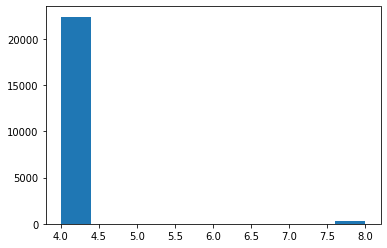

ALMANAC


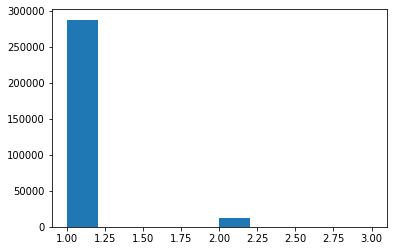

FORCINA
No replicates!!
Mathews


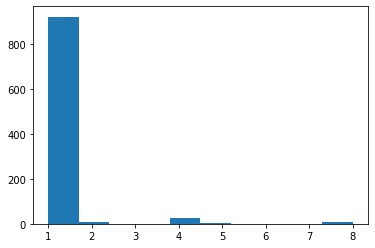

all


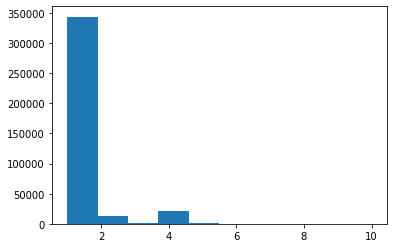

ONEIL and ALMANAC
   synergy_score  correlation dataset1 dataset2
0    synergy_zip     0.089408    ONEIL  ALMANAC
1  synergy_bliss     0.121477    ONEIL  ALMANAC
2  synergy_loewe     0.245491    ONEIL  ALMANAC
3    synergy_hsa     0.177108    ONEIL  ALMANAC
4              S     0.202566    ONEIL  ALMANAC
5            css     0.341522    ONEIL  ALMANAC
ONEIL and FORCINA
No replicates betwen ONEIL and FORCINA
None
ONEIL and Mathews
No replicates betwen ONEIL and Mathews
None
ALMANAC and FORCINA
No replicates betwen ALMANAC and FORCINA
None
ALMANAC and Mathews
No replicates betwen ALMANAC and Mathews
None
FORCINA and Mathews
No replicates betwen FORCINA and Mathews
None


In [49]:
df_comb["drug_cellline_pairs"] = ['_'.join(sorted([r.drug_col,r.drug_row])+[r.cell_line_name]) for _,r in df_comb.iterrows()]
all_rep = []
for study_name in ["ONEIL", "ALMANAC", "FORCINA", "Mathews", "all"]:
    print(study_name)
    rep = within_dataset_replicates_comb(df_comb, study_name)
    #print(rep)
    all_rep.append(rep)


for study_name_1, study_name_2 in list(combinations(["ONEIL", "ALMANAC", "FORCINA", "Mathews"],2)):
    print(study_name_1 + " and " + study_name_2 )
    rep = inter_dataset_replicates_comb(df_comb, study_name_1, study_name_2)
    print(rep)
    try:
        all_rep.append(rep)
    except:
        pass

all_rep = pd.concat(all_rep)
all_rep.to_csv('combination_score_rep.csv', index = False)